# Setup

In [1]:
import gym
import logging
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
print("TensorFlow Ver: ", tf.__version__)
print("Eager Execution:", tf.executing_eagerly())

TensorFlow Ver:  2.0.0-dev20190129
Eager Execution: True


In [4]:
# eager by default!
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


# Advantage Actor-Critic with TensorFlow 2.0

## Policy & Value Model Class

In [5]:
class ProbabilityDistribution(tf.keras.Model):
    def call(self, logits):
        # sample a random categorical action from given logits
        return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        # no tf.get_variable(), just simple Keras API
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        # logits are unnormalized log probabilities
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs):
        # inputs is a numpy array, convert to Tensor
        x = tf.convert_to_tensor(inputs)
        # separate hidden layers from the same input tensor
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        # executes call() under the hood
        logits, value = self.predict(obs)
        action = self.dist.predict(logits)
        # a simpler option, will become clear later why we don't use it
        # action = tf.random.categorical(logits, 1)
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

## Advantage Actor-Critic Agent Class

In [6]:
class A2CAgent:
    def __init__(self, model):
        # hyperparameters for loss terms, gamma is the discount coefficient
        self.params = {
            'gamma': 0.99,
            'value': 0.5,
            'entropy': 0.0001
        }
        self.model = model
        self.model.compile(
            optimizer=ko.RMSprop(lr=0.0007),
            # define separate losses for policy logits and value estimate
            loss=[self._logits_loss, self._value_loss]
        )
    
    def train(self, env, batch_sz=32, updates=1000):
        # storage helpers for a single batch of data
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        # training loop: collect samples, send to optimizer, repeat updates times
        ep_rews = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rews[-1] += rewards[step]
                if dones[step]:
                    ep_rews.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (len(ep_rews)-1, ep_rews[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            # a trick to input actions and advantages through same API
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            # performs a full training step on the collected batch
            # note: no need to mess around with gradients, Keras API handles it
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update+1, updates, losses))
        return ep_rews

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _returns_advantages(self, rewards, dones, values, next_value):
        # next_value is the bootstrap value estimate of a future state (the critic)
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # returns are calculated as discounted sum of future rewards
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.params['gamma'] * returns[t+1] * (1-dones[t])
        returns = returns[:-1]
        # advantages are returns - baseline, value estimates in our case
        advantages = returns - values
        return returns, advantages
    
    def _value_loss(self, returns, value):
        # value loss is typically MSE between value estimates and returns
        return self.params['value']*kls.mean_squared_error(returns, value)

    def _logits_loss(self, acts_and_advs, logits):
        # a trick to input actions and advantages through same API
        actions, advantages = tf.split(acts_and_advs, 2, axis=-1)
        # sparse categorical CE loss obj that supports sample_weight arg on call()
        # from_logits argument ensures transformation into normalized probabilities
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # policy loss is defined by policy gradients, weighted by advantages
        # note: we only calculate the loss on the actions we've actually taken
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # entropy loss can be calculated via CE over itself
        entropy_loss = kls.categorical_crossentropy(logits, logits, from_logits=True)
        # here signs are flipped because optimizer minimizes
        return policy_loss - self.params['entropy']*entropy_loss

In [7]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

(array(0), array([0.00385585], dtype=float32))

# Training A2C Agent & Results

In [8]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

## Testing with Random Weights

In [9]:
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 21 out of 200


In [10]:
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.INFO)

rewards_history = agent.train(env)
print("Finished training.")

I0129 21:42:27.993556 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 001, Reward: 021
I0129 21:42:28.005037 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 002, Reward: 008
I0129 21:42:28.754441 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 003, Reward: 019
I0129 21:42:28.785546 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 004, Reward: 029
I0129 21:42:28.810066 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 005, Reward: 022
I0129 21:42:28.823668 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 006, Reward: 013
I0129 21:42:28.839110 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 007, Reward: 015
I0129 21:42:28.868976 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 008, Reward: 027
I0129 21:42:28.891335 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 009, Reward: 020
I0129 21:42:28.906036 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 010, Reward: 015
I0129 21:4

I0129 21:42:31.270384 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 084, Reward: 016
I0129 21:42:31.309555 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 085, Reward: 038
I0129 21:42:31.321449 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 086, Reward: 012
I0129 21:42:31.361980 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 087, Reward: 040
I0129 21:42:31.391618 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 088, Reward: 028
I0129 21:42:31.409665 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 089, Reward: 012
I0129 21:42:31.453369 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 090, Reward: 032
I0129 21:42:31.500487 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 091, Reward: 046
I0129 21:42:31.660805 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 092, Reward: 157
I0129 21:42:31.680926 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 093, Reward: 018
I0129 21:4

I0129 21:42:35.508218 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 167, Reward: 098
I0129 21:42:35.535000 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 168, Reward: 021
I0129 21:42:35.580738 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 169, Reward: 045
I0129 21:42:35.655193 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 170, Reward: 076
I0129 21:42:35.691702 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 171, Reward: 037
I0129 21:42:35.725309 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 172, Reward: 033
I0129 21:42:35.787838 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 173, Reward: 063
I0129 21:42:35.909418 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 174, Reward: 116
I0129 21:42:35.936223 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 175, Reward: 025
I0129 21:42:36.071569 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 176, Reward: 142
I0129 21:4

I0129 21:42:41.083143 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 250, Reward: 075
I0129 21:42:41.206885 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 251, Reward: 120
I0129 21:42:41.298710 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 252, Reward: 090
I0129 21:42:41.411213 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 253, Reward: 107
I0129 21:42:41.445741 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 254, Reward: 035
I0129 21:42:41.603706 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 255, Reward: 165
I0129 21:42:41.653836 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 256, Reward: 049
I0129 21:42:41.805564 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 257, Reward: 148
I0129 21:42:41.878402 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 258, Reward: 077
I0129 21:42:41.912213 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 259, Reward: 035
I0129 21:4

I0129 21:42:50.613063 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 333, Reward: 200
I0129 21:42:50.773324 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 334, Reward: 163
I0129 21:42:50.955800 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 335, Reward: 193
I0129 21:42:51.144610 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 336, Reward: 200
I0129 21:42:51.327898 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 337, Reward: 192
I0129 21:42:51.468089 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 338, Reward: 147
I0129 21:42:51.646789 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 339, Reward: 186
I0129 21:42:51.837058 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 340, Reward: 200
I0129 21:42:51.931279 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 341, Reward: 098
I0129 21:42:52.123111 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 342, Reward: 200
I0129 21:4

Finished training.


## Testing with Trained Model

In [11]:
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 200 out of 200


## Training Rewards History

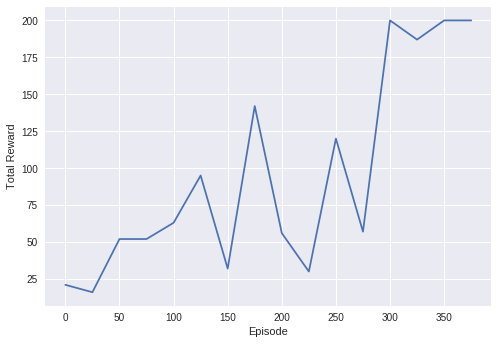

In [12]:
plt.style.use('seaborn')
plt.plot(np.arange(0, len(rewards_history), 25), rewards_history[::25])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Static Computational Graph

In [13]:
with tf.Graph().as_default():
    print("Eager Execution:", tf.executing_eagerly()) # False

    model = Model(num_actions=env.action_space.n)
    agent = A2CAgent(model)

    rewards_history = agent.train(env)
    print("Finished training, testing...")
    print("Total Episode Reward: %d out of 200" % agent.test(env))

W0129 21:43:00.822398 140353255156608 deprecation.py:506] From /home/inoryy/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1253: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Eager Execution: False


I0129 21:43:00.930138 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 001, Reward: 027
W0129 21:43:01.029428 140353255156608 deprecation.py:506] From /home/inoryy/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:123: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
I0129 21:43:01.729957 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 002, Reward: 021
I0129 21:43:01.795073 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 003, Reward: 025
I0129 21:43:01.843012 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 004, Reward: 021
I0129 21:43:01.895429 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 005, Reward: 028
I0129 21:43:01.968557 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode:

I0129 21:43:07.685512 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 080, Reward: 025
I0129 21:43:07.728216 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 081, Reward: 021
I0129 21:43:07.820192 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 082, Reward: 046
I0129 21:43:07.865125 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 083, Reward: 022
I0129 21:43:07.948640 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 084, Reward: 044
I0129 21:43:08.043764 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 085, Reward: 047
I0129 21:43:08.203566 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 086, Reward: 085
I0129 21:43:08.307271 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 087, Reward: 053
I0129 21:43:08.428275 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 088, Reward: 061
I0129 21:43:08.499127 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 089, Reward: 037
I0129 21:4

I0129 21:43:15.504725 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 163, Reward: 042
I0129 21:43:15.625416 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 164, Reward: 065
I0129 21:43:15.757290 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 165, Reward: 072
I0129 21:43:15.867166 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 166, Reward: 059
I0129 21:43:16.027540 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 167, Reward: 085
I0129 21:43:16.098886 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 168, Reward: 039
I0129 21:43:16.249382 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 169, Reward: 083
I0129 21:43:16.403982 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 170, Reward: 079
I0129 21:43:16.460915 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 171, Reward: 029
I0129 21:43:16.539019 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 172, Reward: 042
I0129 21:4

I0129 21:43:26.589373 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 246, Reward: 041
I0129 21:43:26.875794 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 247, Reward: 157
I0129 21:43:27.049731 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 248, Reward: 092
I0129 21:43:27.224856 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 249, Reward: 097
I0129 21:43:27.413815 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 250, Reward: 105
I0129 21:43:27.542635 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 251, Reward: 065
I0129 21:43:27.721423 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 252, Reward: 093
I0129 21:43:27.882043 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 253, Reward: 089
I0129 21:43:27.919570 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 254, Reward: 022
I0129 21:43:28.156702 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 255, Reward: 130
I0129 21:4

I0129 21:43:47.430181 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 329, Reward: 200
I0129 21:43:47.693366 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 330, Reward: 147
I0129 21:43:48.056469 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 331, Reward: 200
I0129 21:43:48.333629 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 332, Reward: 151
I0129 21:43:48.658412 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 333, Reward: 174
I0129 21:43:49.024322 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 334, Reward: 200
I0129 21:43:49.381057 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 335, Reward: 200
I0129 21:43:49.745054 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 336, Reward: 200
I0129 21:43:50.115255 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 337, Reward: 200
I0129 21:43:50.429391 140353255156608 <ipython-input-6-ca35cd767901>:34] Episode: 338, Reward: 174
I0129 21:4

Finished training, testing...
Total Episode Reward: 200 out of 200


# Benchmarks

In [14]:
env = gym.make('CartPole-v0')
obs = np.repeat(env.reset()[None, :], 100000, axis=0)

In [15]:
# Note: wall time doesn't show the whole picture, better to compare CPU time

## Eager Benchmark

In [16]:
%%time

model = Model(env.action_space.n)
model.run_eagerly = True

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model(obs)
# _ = model.predict(obs)

Eager Execution:   True
Eager Keras Model: True
CPU times: user 537 ms, sys: 1.63 s, total: 2.17 s
Wall time: 145 ms


## Static Benchmark

In [17]:
%%time

with tf.Graph().as_default():
    model = Model(env.action_space.n)

    print("Eager Execution:  ", tf.executing_eagerly())
    print("Eager Keras Model:", model.run_eagerly)

    _ = model.predict(obs)

Eager Execution:   False
Eager Keras Model: False
CPU times: user 792 ms, sys: 99.3 ms, total: 891 ms
Wall time: 683 ms


## Default Benchmark

In [18]:
%%time

model = Model(env.action_space.n)

print("Eager Execution:  ", tf.executing_eagerly())
print("Eager Keras Model:", model.run_eagerly)

_ = model.predict(obs)

Eager Execution:   True
Eager Keras Model: False
CPU times: user 919 ms, sys: 37.4 ms, total: 956 ms
Wall time: 723 ms
